**Building and Training a deep learning model to predict the gender and age of individuals from images.**


**IMPORTING LIBRARIES :**

* Import necessary libraries : pandas for data manipulation, numpy for numerical operations, os for file operations, matplotlib.pyplot for plotting, seaborn for statistical visualization, and tqdm for progress bars during loops.
*  Ignore warning messages.
*  %matplotlib inline is a magic command that allows matplotlib plots to be displayed directly in the notebook.
* Import TensorFlow and Keras modules for building the neural network model.


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


**LOADING THE DATASET FROM KAGGLE AND UNZIPPING THE DATASET**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
print("Downloading dataset : ")
!kaggle datasets download -d jangedoo/utkface-new
print("Downloaded Successfully!")

 95% 316M/331M [00:03<00:00, 96.8MB/s]
100% 331M/331M [00:03<00:00, 94.8MB/s]
Downloaded Successfully!


In [ ]:
%%capture
!unzip utkface-new.zip

In [ ]:
BASE_DIR = '/content/UTKFace'

*Initialize lists to store image paths, age labels, and gender labels.
Iterate through the files in the directory specified by BASE_DIR and extract information about age and gender from the filenames.*

In [ ]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

*Create a DataFrame df to store the image paths, age labels, and gender labels.
Populate the DataFrame with the collected data and display the first few rows using head().*

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  /content/UTKFace/1_0_4_20161221193016140.jpg.c...    1       0
1  /content/UTKFace/2_0_2_20161219203358108.jpg.c...    2       0
2  /content/UTKFace/16_0_0_20170110232217844.jpg....   16       0
3  /content/UTKFace/67_1_0_20170104213602661.jpg....   67       1
4  /content/UTKFace/37_0_2_20170116184939699.jpg....   37       0

*Create a dictionary to map gender labels (0 and 1) to their corresponding strings ('Male' and 'Female').*

In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

 **EXPLORATORY DATA ANALYSIS**

*Drop the first row from the DataFrame using iloc.
Reset the index of the DataFrame after dropping the row.Open an image using PIL (Python Imaging Library).
Create a plot figure and display the image using imshow().
The axis('off') command removes axis labels and ticks.
Finally, display the plot using show().*

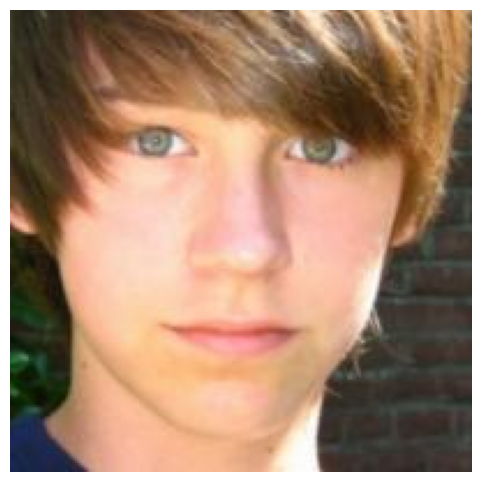

In [ ]:
from PIL import Image

df = df.iloc[1:]  # Drop the first row

# Reset the index after dropping the first row
df.reset_index(drop=True, inplace=True)

# Now you can access the first image using index 0
img = Image.open(df['image'][0])

plt.figure(figsize=(6, 6))  # Adjust the figure size if needed
plt.axis('off')
plt.imshow(img)
plt.show()


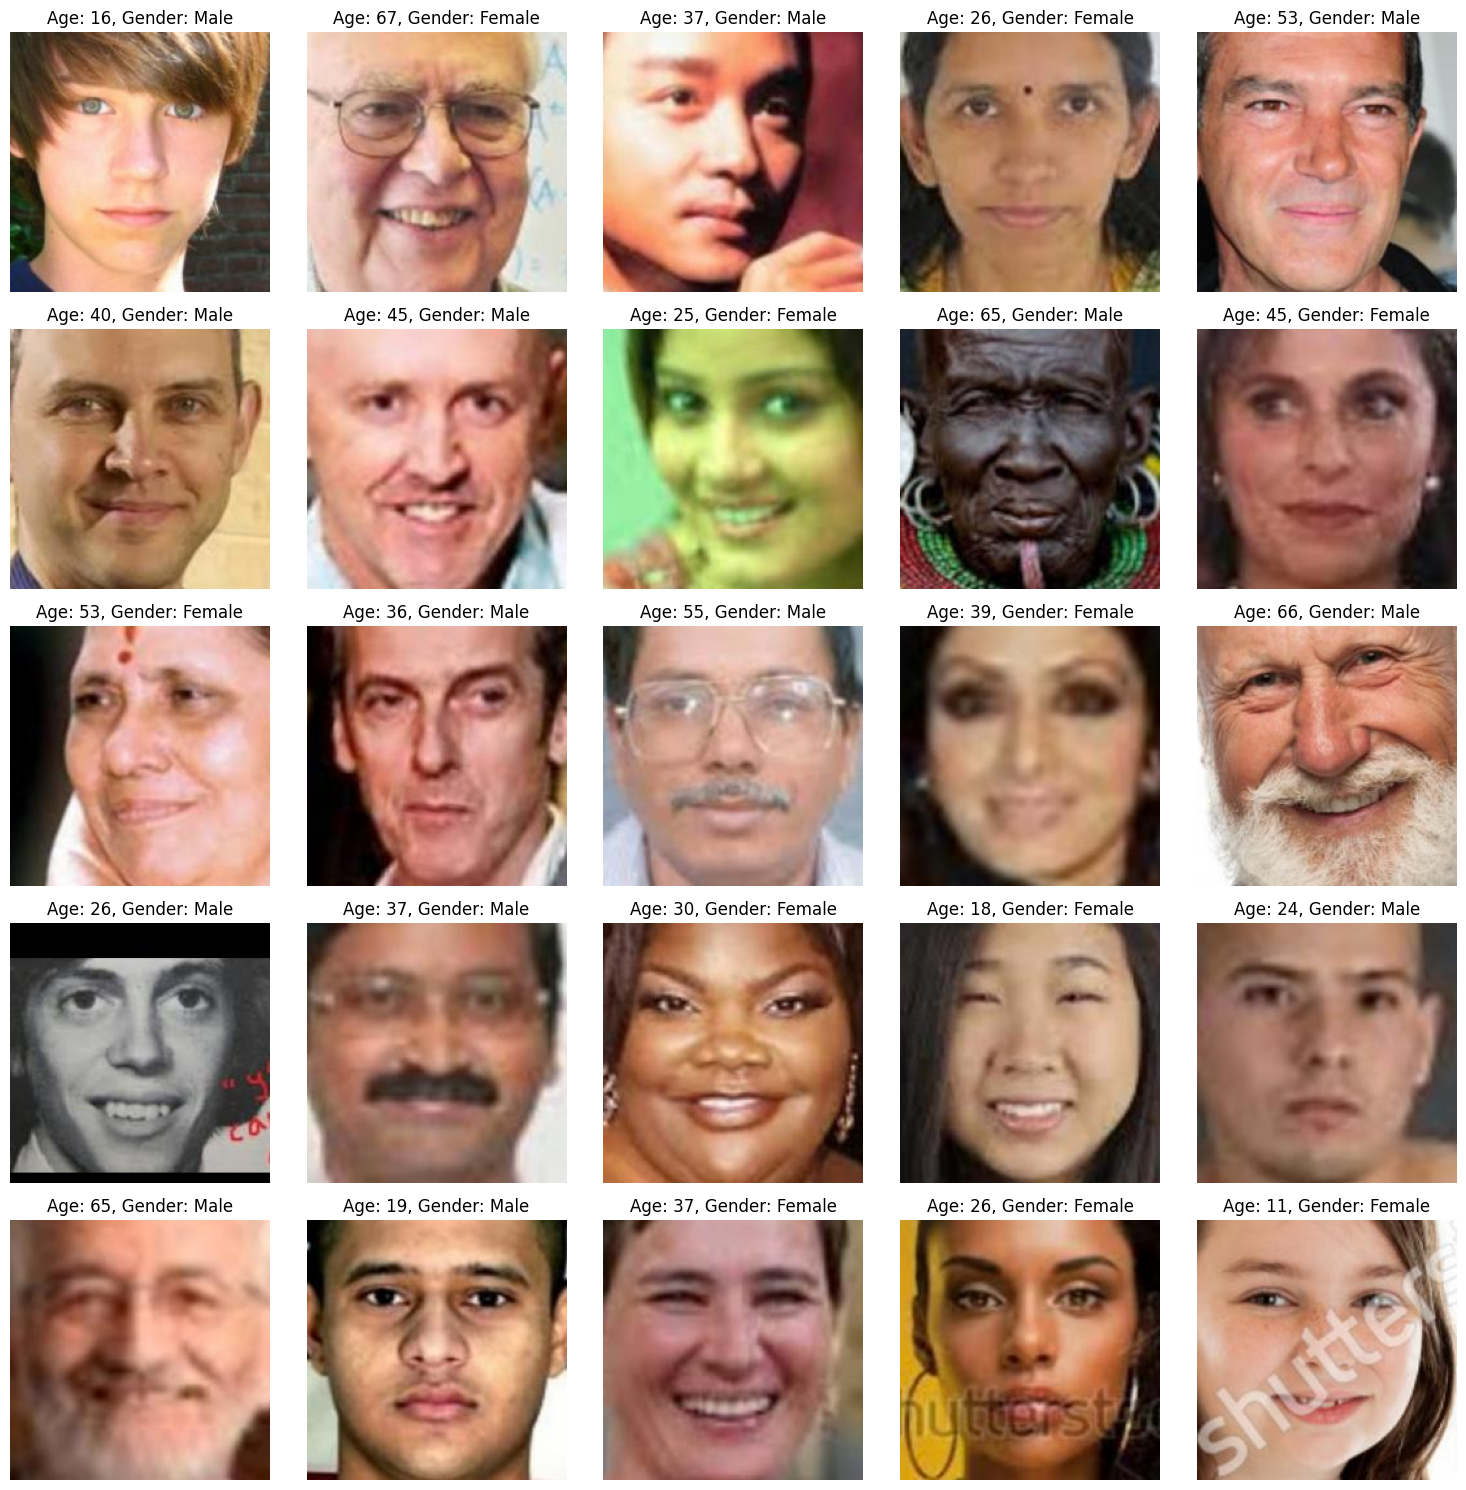

In [ ]:
# Adjust the number of rows and columns in the grid
num_rows = 5
num_cols = 5

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Loop through the grid and display images
for i, ax in enumerate(axes.flat):
    if i < len(df):
        img = Image.open(df['image'][i])
        ax.imshow(img)
        ax.set_title(f"Age: {df['age'][i]}, Gender: {gender_dict[df['gender'][i]]}")
        ax.axis('off')

# Adjust layout and show the grid
plt.tight_layout()
plt.show()

In [ ]:
df.head()

image  age  gender
0  /content/UTKFace/16_0_0_20170110232217844.jpg....   16       0
1  /content/UTKFace/67_1_0_20170104213602661.jpg....   67       1
2  /content/UTKFace/37_0_2_20170116184939699.jpg....   37       0
3  /content/UTKFace/26_1_3_20170119193046825.jpg....   26       1
4  /content/UTKFace/53_0_0_20170111171747402.jpg....   53       0

*Create a histogram using seaborn to visualize the distribution of ages in the dataset.
Print the counts of each gender category.*

<Axes: xlabel='age', ylabel='Density'>

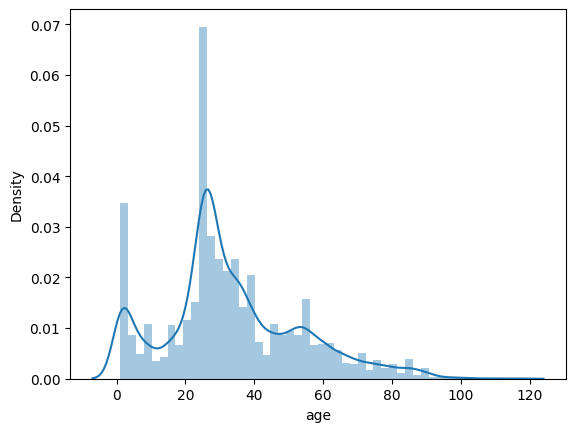

In [ ]:
sns.distplot(df['age'])

In [ ]:
print(df['gender'].value_counts())


0    12389
1    11317
Name: gender, dtype: int64


*Create a count plot to visualize the distribution of genders in the dataset.
Set labels and title for the plot.
Display the plot.*

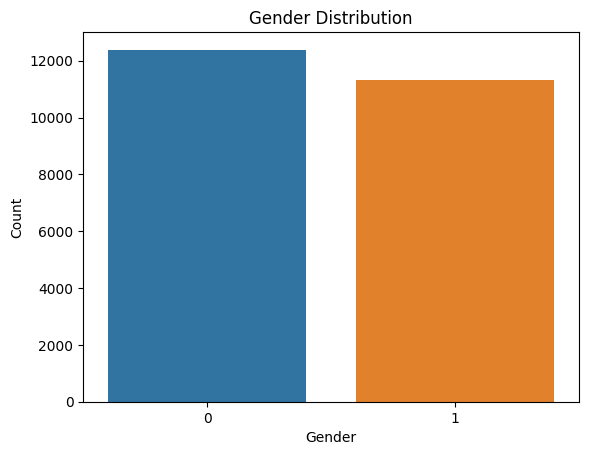

In [ ]:
sns.countplot(data=df, x='gender')

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

*Create a large plot grid to display a selection of images.
Select the first 25 rows from the DataFrame.
Iterate through the selected rows and display each image along with age and gender information.*

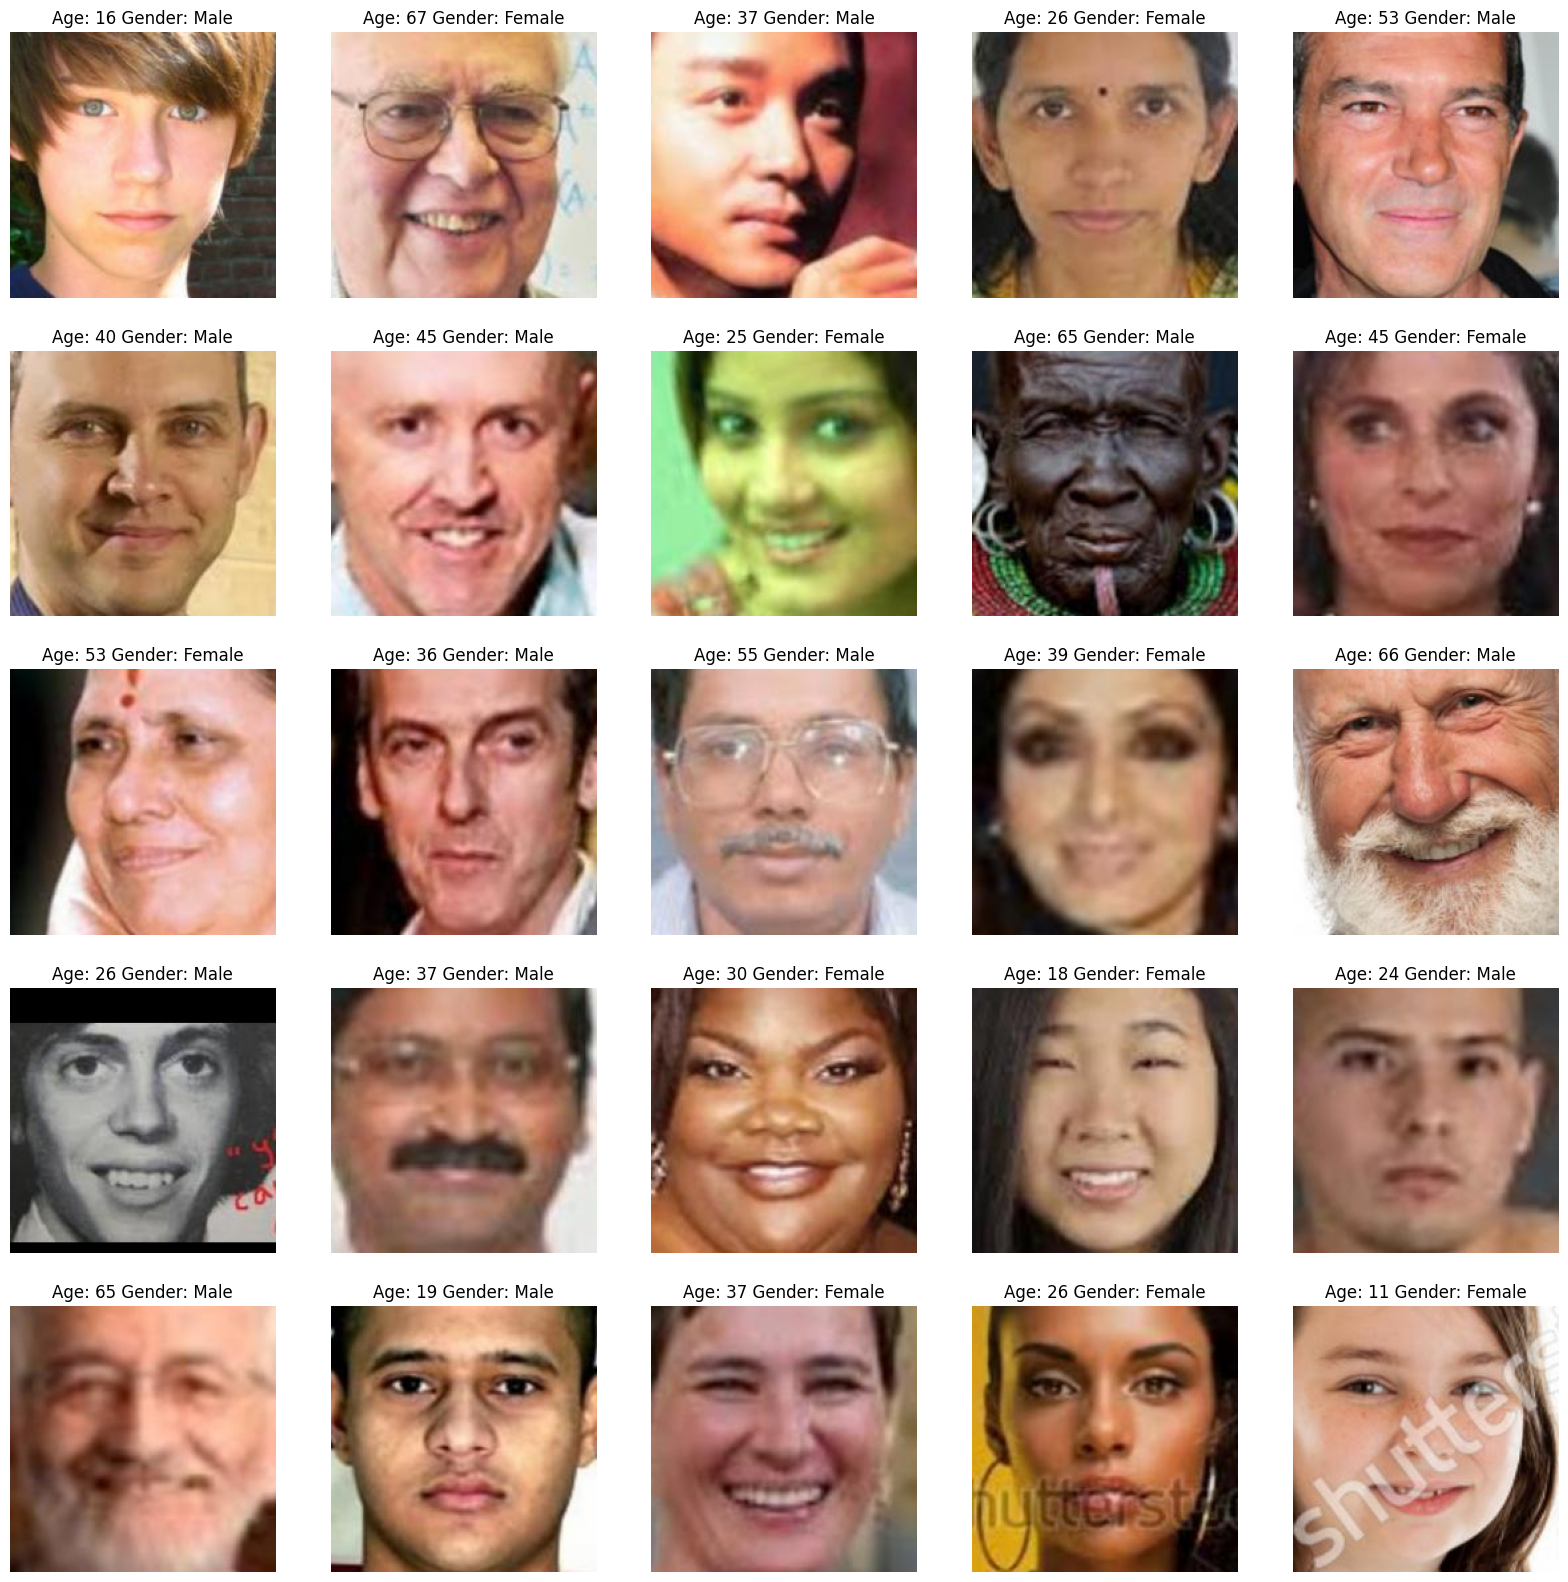

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

**FEATURE EXTRACTION**

*Define a function extract_features to preprocess images for training.
Load images in grayscale, resize them to 128x128 pixels, and store them in an array.
Return the processed image data.*

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features


*Call the extract_features function to preprocess the images and store them in the variable X.
Print the shape of X, which represents the number of images and their dimensions.*

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23706 [00:00<?, ?it/s]

In [ ]:
X.shape

(23706, 128, 128, 1)

*Normalize the image data by dividing pixel values by 255.0 to scale them between 0 and 1.
Convert gender and age labels to NumPy arrays.*

In [ ]:
# normalize the images
X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

*Define the input shape for the neural network model.
Create an input layer using the specified input shape.*

In [ ]:
input_shape = (128, 128, 1)

**CNN MODEL CREATION**

*Create a series of convolutional layers with increasing depths and pooling layers using the Keras API.
These layers will extract features from the input images.Flatten the output of the convolutional layers.
Create fully connected (dense) layers to process the flattened features.Create output layers for gender prediction (using sigmoid activation) and age prediction (using ReLU activation).Create a Keras model with the defined input and output layers.Compile the model with binary cross-entropy loss for gender prediction and mean absolute error (MAE) for age prediction.
Use the Adam optimizer and track accuracy as a metric.*

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

*Visualize the model architecture using the plot_model function from Keras.*

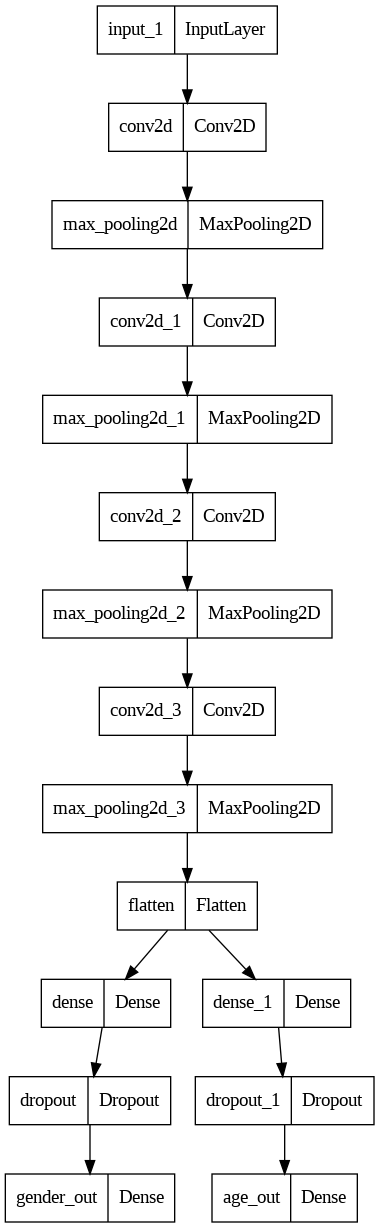

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

*Train the model using the preprocessed image data (X) and the gender and age labels (y_gender and y_age).
Use a batch size of 32, run for 30 epochs, and split the data into training and validation sets (80-20%).*

In [ ]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

**PLOT THE RESULTS**

*Plot the training and validation accuracy for gender prediction.*

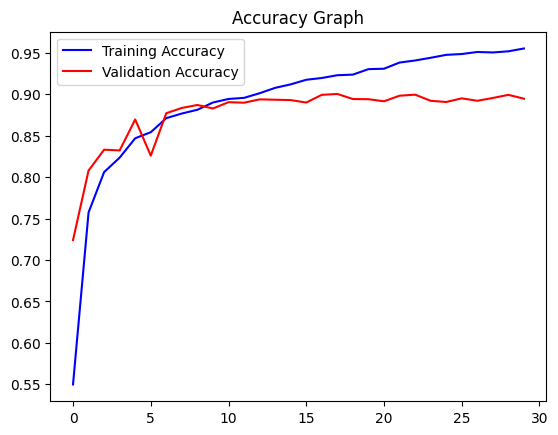

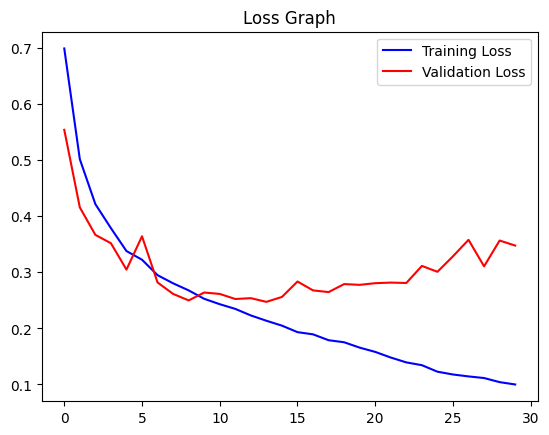

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

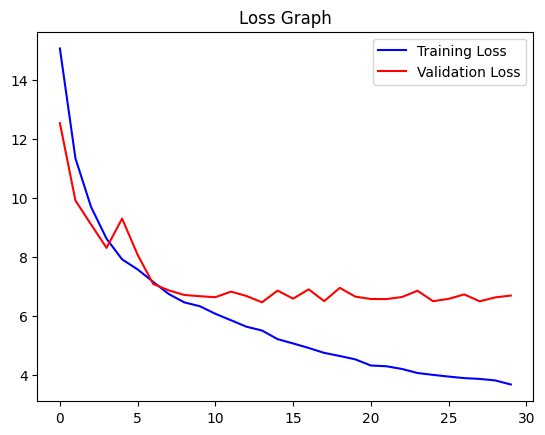

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

**PREDICTION WITH TEST DATA**

Original Gender: Female Original Age: 18
1/1 [==============================] - 0s 272ms/step
Predicted Gender: Female Predicted Age: 19


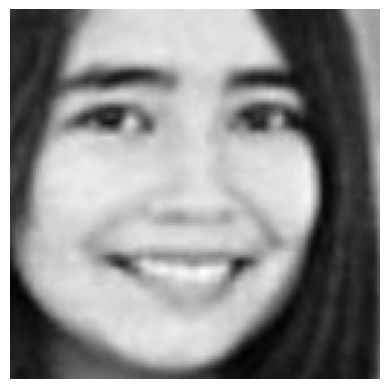

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 78
1/1 [==============================] - 0s 34ms/step
Predicted Gender: Male Predicted Age: 65


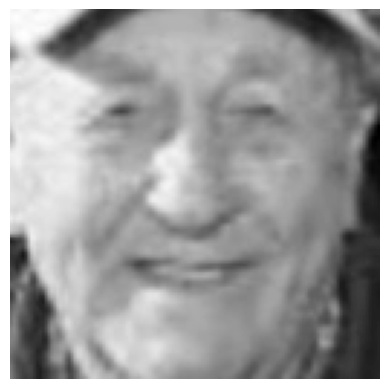

In [ ]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

1/1 [==============================] - 0s 32ms/step
Original Gender: Male Original Age: 53
Predicted Gender: Male Predicted Age: 53


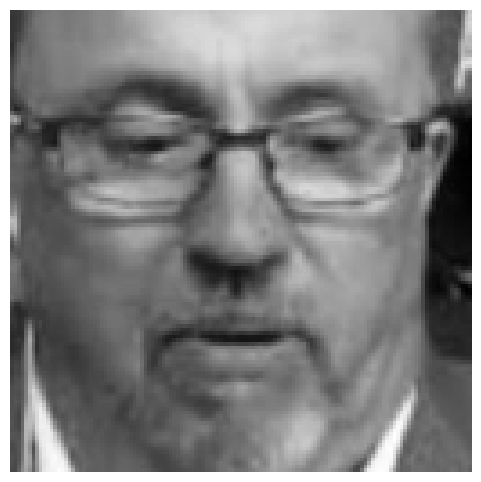

In [54]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Generate a random index
random_index = random.randint(0, len(X) - 1)

# Get the random image and labels
random_image = X[random_index]
random_gender = y_gender[random_index]
random_age = y_age[random_index]

# Preprocess the image for prediction
input_image = random_image.reshape(1, 128, 128, 1)  # Reshape for model input

# Predict using the model
pred = model.predict(input_image)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

# Display original and predicted information
print("Original Gender:", gender_dict[random_gender], "Original Age:", random_age)
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Display the random image
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(random_image.reshape(128, 128), cmap='gray')
plt.show()
